# Excercise on Autoencoder and Variational Autoencoder

**Goal:** Aim of this excercise is to implement an Autoencoder (AE) similar to the tutorial but this time for the sea level pressure in the North Atlantic and using a Convolutional Network architecture for the encoder. 


In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ctp

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

plt.style.use("./../plotting.mplstyle")

## 1. Familierize yourself with the data

Sea level pressure (SLP) in the North Atlantic highly affects the climate over Europe. 

The monthly SLP data from 1950-1979 and 1979-2021 are taken from [Copernicus ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview). The data are cropped over the Northern Atlantic 20°-80°N, 90°W-40°E, regridded on a $5^\circ \times 5^\circ$ resolution, detrended and then subtracted from their monthly climatology. The data can be found in ```04_vae/data/slpa_...```.



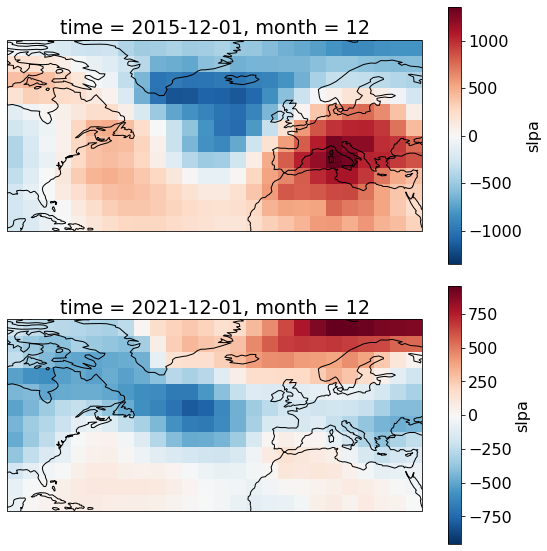

In [2]:
# Read data from file
da = xr.open_dataset("./data/slpa_1950_2021.nc")['slpa']

# Plot last year december, i.e. '2015-12'
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,8), subplot_kw=dict(
    projection= ctp.crs.PlateCarree())
)
da.sel(time='2015-12').plot(ax=ax1, transform=ctp.crs.PlateCarree())
ax1.coastlines()
da.sel(time='2021-12').plot(ax=ax2, transform=ctp.crs.PlateCarree())
ax2.coastlines()


### The North Atlantic oscillation (NAO)

The NAO is a weather phenomenon over the North Atlantic Ocean characterized by differences in SLP between the Icelandic Low and the Azores high. The NAO can be either in positive or negative phase depending on the sign of the differences. [Wiki](https://en.wikipedia.org/wiki/North_Atlantic_oscillation)

There are different representative time-series of the NAO. One is based on pressure differences between certain points (Icelandic Low and the Azores high) [see [ClimateDataGuide](https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-station-based)] and the other is based on Principal Component Analysis [see [ClimateDataGuide](https://climatedataguide.ucar.edu/climate-data/hurrell-north-atlantic-oscillation-nao-index-pc-based)].

***Exercise 1**: Construct the station-based NAO index, i.e. the SLP differences between Lisbon and Reykjavík.*

Hint:
- Select the location of Lisbon and Reykjavik
- Normalize each time-series by its standard deviation, i.e. [standard score normalization](https://en.wikipedia.org/wiki/Standard_score) 
- Subtract the time-series from another 

In [ ]:
def normalize(da):
    """Normalize data by its standard deviation.


    Args:
        da (xr.DataArray): Input time-series.

    Returns:
        (xr.DataArray) Normalized time-series.
    """
    
    # Your code here
    #===============
    
    
    #===============
    return 


# Select stations, normalize and subtract for NAO index. Plot the index.
# Your code here:
#===============


#===============


## 2. Preprocess your data

As shown in the tutorial we need to define a Dataset class for training our Autoencoder. 

This time we want to train a Convolutional Neural Network as an encoder and decoder network. Therefore, we have to change our dataset class, such that our output of the *__getitem__* function is of dimension (1, x_dim, y_dim), see [nn.torch.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html?highlight=conv2d#torch.nn.Conv2d).

***Exercise 2**: Fill the missing code in the dataset class given below such that we can train a CNN with it.*

Hint:
- we need to normalize the data using standard score normalization (see Exercise 1)
- the output x of our ```_getitem_``` function should be of dimension (1, lat, lon)
- you could use ```np.newaxis``` for adding an additional dimension 

In [ ]:
class SLPA(Dataset):
    """Dataset of SSTA used for pytorch.

    Args:
        dataarray (xr.DataArray): Dataarray containing SSTA. 
    """
    def __init__(self, dataarray):
        self.time = dataarray['time'].data
        self.lat = dataarray['lat'].data
        self.lon = dataarray['lon'].data
        
        # Normalize dataarray by standard deviation
        self.dataarray = normalize(dataarray)
        

    def __len__(self):
        """Returns the number of datapoints."""
        return len(self.dataarray)
    

    def __getitem__(self, idx):
        """Required function to get items of dataset.

        Args:
            idx (int): Index to get datapoint.

        Returns:
            x (torch.Tensor): Datapoint of dimension (channel, lat, lon)
            l (dict): Label of datapoint. In this case just the index.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Return the datapoint with index x such that we can use it as an input to nn.torch.Conv2d
        # Your code here
        # ==================================
        x = None
        
        
        # ==================================
        label = {'idx': idx}

        return x, label
    
    def get_map(self, x, name=None):
        """Reshape flattened vector with removed NaNs to xarray map.

        Args:
            data (torch.tensor): (x_dim) Flatten datapoint with NaNs removed

        Return:
            map (np.ndarray): 2d-map
        """
        if torch.is_tensor(x):
            x = x.to('cpu').detach().numpy()
        
        if x.shape[0] == 1:
            x = x[0,:,:].copy()

        dmap = xr.DataArray(
            data=x,
            dims=['lat', 'lon'],
            coords=dict(lat=self.lat, lon=self.lon)
        )
        return dmap 

Initialize our dataset.

In [ ]:
dataset = SLPA(da)
# Sample datapoint
x, l = dataset[0]
x_dim = x.shape
print(f"Shape of datapoint: {x.shape}")

Split the data into training and validation set:

In [ ]:
n_training = int(len(dataset) * 0.8)
(train_data, val_data) = torch.utils.data.random_split(dataset, [n_training, len(dataset) - n_training])

# Define data loader
batch_size = 10
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

## Autoencoder

**Exercise 3:** Adapt the following Autoencoder class by using a Convolutional Encoder architecture. 

Hints: 
- Typical encoder architure stack blocks of Conv -> MaxPool -> ReLU followed by a Linear layer in the last layer.
- Check the documentation of [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
- Use MaxPool layer for downsampling. Read documentation of [torch.nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d)
- When downsampling take care that you choose the Kernel size, stride and padding accordingly, see for instance [here](https://dingyan89.medium.com/calculating-parameters-of-convolutional-and-fully-connected-layers-with-keras-186590df36c6). The following equation must hold in each dimension

$output = \frac{input - kernel + 2 * padding}{stride}+1$

- The last layer of the encoder is always a [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) layer
- You have to use the [torch.nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) before the Linear layer
- You can try to use [torch.nn.ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html#torch.nn.ConvTranspose2d) for the decoder or just use a stack of 2 Linear layer as was used in the tutorial.

In [ ]:
class CNNAE(nn.Module):
    """Auto encoder.

    Args:
        z_dim (int): Dimension of latent space. 
        encoder ([type]): Encoder NN.
        decoder ([type]): Decoder NN.
    """

    def __init__(self, x_dim, z_dim):
        super().__init__()
        self.z_dim = z_dim
        self.device = torch.device(
                'cuda' if torch.cuda.is_available() else 'cpu')
        
        # Implement an convolutional network encoder and a decoder (decoder can also be just linear) 
        # Your Code here
        # ===============================================================================
        self. encoder = nn.Sequential(
                # ...  
        ).to(self.device)

        self.decoder = nn.Sequential(
                # ...
        ).to(self.device)
        
        # ===============================================================================

    
    def forward(self, x):
        """Pass through encoder and decoder.
        
        Args:
            x (tensor): (batch, x_dim) Input to AE.
        
        Return:
            x_hat (tensor): (batch, x_dim ) Reconstruction of x.
            z (tensor): (batch, z_dim) Vector in latent space.
        """
        z = self.encoder(x)
        x_hat = self.decoder(z)

        return x_hat, z
    
    def loss(self, x):
        """Loss function of AE.

        Args:
            x (torch.Tensor): (batch, x_dim) Input to AE.

        Returns:
            rec_loss (torch.Tensor): Reconstruction loss between input and rec.
        """
        
        # Encode and decoder input 
        x_hat, z = self.forward(x)
        # Mean square error between reconstructed and input
        rec_loss_pointwise = F.mse_loss(x_hat, x, reduction='none')
        # Sum of point wise MSE
        rec_loss = torch.sum(torch.flatten(rec_loss_pointwise, start_dim=1), dim=-1)
        
        return rec_loss.mean()

In [ ]:
ae = CNNAE(x_dim, z_dim=2)

print("Number of trainable parameters of our model:",
      sum(p.numel() for p in ae.parameters() if p.requires_grad))

*Note: Compared to the Linear architecture in the tutorial, CNN architecture have a much smaller number of parameters by performing equal performances on 2d data. One main reason is that they make use of the spatial correlation between neighboring points.*

### Training an NN

The training proceedure is the same es in the tutorial. We train the NN by computing the loss for each minibatch and update the gradients using backpropagation. We iterate $N$ epochs over the whole training data. No gradients are computed for the validation data.

*Optional: You can try different learning rates and epochs or even optimizers if you have time in the end.*

In [ ]:
def train_epoch(model, dataloader, optimizer):
    """Train model for one epoch.

    Args:
        model (nn.Module): Model to train
        dataloader (torch.Dataloader): Dataloader of trainingsdata.
        optimizer (torch.optim): Optimizer of model parameters.

    Returns:
        mean_epoch_loss (float): training loss of one epoch
    """
    # set model into training mode
    model.train()

    epoch_loss = 0.0
    for i, data in enumerate(dataloader):
        # Set gradients to zero in the beginning of each batch
        optimizer.zero_grad()

        # encoding and decoding
        data, _ = data
        data = data.to(model.device)

        # loss function
        loss = model.loss(data)

        # backward prop and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    mean_epoch_loss = epoch_loss / len(dataloader)

    return mean_epoch_loss


def validate_epoch(model, dataloader):
    """Validate model for one epoch.

    Args:
        model (nn.Module): VAE model to train.
        dataloader (torch.Dataloader): Dataloader of validation data.

    Returns:
        mean_epoch_loss (float): Validation loss of one epoch.
    """
    # Set model into validation mode
    model.eval()

    epoch_loss = 0.0
    # For validation no gradients are computed
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            data, _ = data
            data = data.to(model.device)

            # loss function
            loss = model.loss(data)
            epoch_loss += loss.item()

    mean_epoch_loss = epoch_loss / len(dataloader)

    return mean_epoch_loss

In [ ]:
# The training loop
epochs = 50
learning_rate = 0.001
optimizer = torch.optim.Adam(ae.parameters(), lr=learning_rate)    

train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    val_epoch_loss = validate_epoch(
        ae, val_loader
    )
    train_epoch_loss = train_epoch(
        ae, train_loader, optimizer
    )

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)

We plot the loss to see if our model learned somethin.

In [ ]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='training')
ax.plot(val_loss, label='validation')
ax.set_yscale('linear')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
ax.legend()

**Exercise 4:** Plot the input and reconstruction of the autoencoder for a qualitative comparison.

Hint:
- have a look at the tutorial
- you can use the ```get_map(x)``` function implemented in the ```CNNAE``` class
- watch out the dimensions of $x$

In [ ]:
# select input and construct reconstruction be pushing through AE
# Your code here
# ====================


# ====================

## Latent space

We plot the latent space and analyze which features have been compressed in the low dimensional representation.

In [ ]:
def encoding(model, dataloader):
    """Encoding dataset and store encoding.

    Args:
        model (nn.Module): AE model.
        dataloader (torch.Dataloader): Dataloader 

    Returns:
        encode (dict): Dictionary with encodings.
    """
    with torch.no_grad():
        encode = dict()
        for i, x in enumerate(dataloader):
            x, l = x
            out = model.forward(x.to(model.device))
            z = out[1]
            if i == 0:
                encode['z'] = z.cpu().detach().numpy()
                encode['idx'] = l['idx']
            else:
                encode['z'] = np.vstack([encode['z'], z.cpu().detach().numpy()])
                encode['idx'] = np.concatenate((encode['idx'], l['idx']))
    return encode

encode = encoding(ae, train_loader)

# Plot the encoding
fig, ax = plt.subplots()
ax.plot(encode['z'][:,0], encode['z'][:,1], 'ko')
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")

**Exercise 6:** Similar to the tutorial we want to see if the positive and negative phase of the NAO are seperated in the latent space. Choose the condition where the NOA index is > 2.0 for the positive phase and NOA index < -2.0 for the negative phase.

Hint:
- find the time indices where the stated conditions are valid
- plot the encoding $z$ for these time indices 

In [ ]:
# select z for positive and negative NAO phase and plot them
# Your code here
# ==============


# ==============

## Latent traverse

We can traverse the latent space across different dimensions, as was shown in the tutorial.

**Optional:** You can try different traversal directions. What is a typical positive and negative NAO pattern?

In [ ]:
z_start = torch.Tensor([[0,0]])
z_eps = torch.Tensor([1,0])
z_range = torch.linspace(-8, 8, 5)

# Create traverse through latent space
z_samples = z_start.repeat(len(z_range), 1 ) + z_range.unsqueeze(1) * z_eps


# Plot latent space
fig, ax = plt.subplots()
ax.plot(encode['z'][:,0], encode['z'][:,1], 'ko', label='encoding')
ax.plot(z_samples[:,0], z_samples[:,1], '-o', label='traverse', 
        markersize=10, linewidth=3)
ax.set_xlabel(r"$z_1$")
ax.set_ylabel(r"$z_2$")
ax.legend()

In [ ]:
# Decode z
with torch.no_grad():
    traverse = ae.decoder(z_samples.to(ae.device))
    
# Plot reconstructions
fig, axs = plt.subplots(
    1, len(z_range), figsize=(len(z_range)*5, 3), 
    subplot_kw=dict(projection= ctp.crs.PlateCarree())
)
for i, rec in enumerate(traverse):
    da_rec = train_data.dataset.get_map(rec)
    da_rec.plot(ax=axs[i], transform=ctp.crs.PlateCarree(), vmin=-4, vmax=4, cmap=mpl.cm.RdBu_r)
    axs[i].coastlines()
    axs[i].set_title(f"z={z_samples[i].tolist()}")

## Comparison of AE to PCA

AE learn complex non-linear transformations to represent the data. PCA is only a linear transformation often used for dimensionality reduction. We can compare the latent spaces of both methods. 

**Exercise 5:** Apply a PCA on the SLP anomaly data, visualize the EOF map of the first two components and plot the latent space where you color points by their NAO phase, i.e. NOA index is > 2.0 for the positive phase and NOA index < -2.0 for the negative phase. Is the latent space of PCA different to AE?  

In [ ]:
from sklearn.decomposition import PCA
X = da.data.reshape(da.shape[0], -1)

# Apply pca on X, plot components and latent space for NAO positive and negative phase
# Your code here
# =============================




# ==============================


We can also compare the station-based and pca-based index of NAO:

In [ ]:
# NAO index based on PC1
nao_pca = X @ pca.components_[0]
nao_pca /= nao_pca.std()

nao_pca = xr.DataArray(data=nao_pca,
                       dims=['time'], 
                       coords=dict(time=da.time))

fig, ax = plt.subplots()
nao_pca.plot(ax=ax, label='PCA-based')
nao.plot(ax=ax, label='station-based', alpha=0.6)
ax.legend()
ax.set_ylabel('NAO')